#QUINCY HERSHEY - ALEX MOORE - ADAM DICHIARA - SCOTT TANG - VINCENT FILARDI
#CS541 Project: MAML CNN
---


In [73]:
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

dir = '/content/drive/MyDrive/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## RESISC45

---

In [74]:
np.random.seed(1)
random.seed(1)
test_size = 0.8
val_size = 0.2
batch_size = 32
MAML_learning_rate1 = 0.0006
MAML_learning_rate2 = 0.0006
CNN_learning_rate = 0.0006
n_epochs = 80
freeze=False
First_Train = False
bce_loss = nn.BCELoss()

In [75]:
class CustomTensorDataset(Dataset):

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform=transform

    def __getitem__(self, index):
        X = self.images[index]
        y = self.labels[index]
        return X, y

    def __len__(self):
        return len(self.images)

def make_dataset(x, y):
    x = torch.tensor(x).permute(0,3,1,2)
    y = torch.tensor(y)
    dset = CustomTensorDataset(x, y)
    return dset

In [76]:
def get_data(dir, mtype):
    if mtype=='MAML': batch_n = batch_size*2
    else: batch_n = batch_size

    data = np.load(dir+'RESISC45_images_96.npy')
    labels = np.load(dir+'RESISC45_classes.npy')
    classes = np.load(dir+'RESISC45_class_names.npy')

    #img_size = train_data.shape[2]
    c_dim = classes.shape[0]

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size, stratify = labels)

    xtrain, xval, ytrain, yval = train_test_split(train_data, train_labels, test_size = val_size)

    trainset = make_dataset(xtrain,ytrain)
    train_loader = DataLoader(trainset, batch_size=int(batch_n), shuffle=True)

    valset = make_dataset(xval, yval)
    val_loader = torch.utils.data.DataLoader(valset, batch_n, drop_last = True, shuffle=True)

    testset = make_dataset(test_data, test_labels)
    test_loader = torch.utils.data.DataLoader(testset, batch_n, drop_last = True, shuffle=True)

    return train_loader, val_loader, test_loader, c_dim, classes

In [77]:
class Conv_Pred(nn.Module):
    def __init__(self):
        super(Conv_Pred, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1) # Input: (batch_size, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv6_bn = nn.BatchNorm2d(1024)
        
        self.fce = nn.Linear(1024, 45)


    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, x):
        x = x/127.5 - 1.0
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))

        z = nn.Softmax(dim=1)(self.fce(x.squeeze()))

        return z

    def save(self, name):
        print('saving...')
        torch.save({
            'model_state_dict': self.state_dict() #,
            #'optimizer_state_dict': self.optimizer.state_dict(),
        }, dir+name+'.pt')

    def load(self, name):
        print('loading...')
        checkpoint = torch.load(dir+name+'.pt')
        self.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

def get_model(mtype, lr=0.0006, train=True):
    model = Conv_Pred().to(device)
    model.weight_init()
    try: model.load(mtype)
    except: pass
    if train == True:
        model.train()
    else:
        model.eval()
    return model


def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)

def one_hot_embedding(labels, dims):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = dims)
    return torch.squeeze(labels)

def accuracy_topk(output, target, topk=(3,)):
    #https://forums.fast.ai/t/return-top-k-accuracy/27658
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

In [78]:
#augmentation_functions.py

class addGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, p=0.5):
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)
        self.p = p
      
    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return img + torch.randn(img.size(), device = device) * self.std + self.mean
        return img
        
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1}, p={2})'.format(self.mean, self.std, self.p)

def applyAugs(img_batch, task_idx, num_augs=7):
    # returns augmented batch of images based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(96,
                                                   scale=(0.5, 1.0),
                                                   ratio=(0.8, 1.0)),
                                                   #interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)
    img_batch = transform(img_batch)
    return img_batch

def getAugmentationTransforms(task_idx, num_augs=7):
    # returns transforms.Compose function of transforms based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(256,
                                                   scale=(0.5, 1.0),
                                                   ratio=(1.0, 1.0),
                                                   interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)

    return transform

# utility functions
# images must be normalized and converted to torch shape before augmentations (3,h,w)
# converted to numpy shape for displaying (h,w,3)

def normalizeImages(x):
  x = x/255.
  return x

def convertToTorch(x):
  x = np.moveaxis(x, 3, 1)
  x = torch.as_tensor(x)
  return x

def convertToNumpy(x):
  # convert back to format for displaying
  x = x.numpy()
  x = np.moveaxis(x, 1, 3)  
  return x

In [79]:
def train(n_epochs, learning_rate, learning_rate1, train_loader, val_loader, c_dim, mtype):
    epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
    i = 0
    tasks = 128
    print_stride = n_epochs // 10

    model = get_model(mtype=mtype)
    model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(1, n_epochs+1):

        losses = []

        for X, y in train_loader:

            y = one_hot_embedding(y, c_dim).float().to(device)

            if mtype=='MAML':

                X1 = X[:int(X.shape[0]/2)].float().clone().to(device)
                X2 = X[int(X.shape[0]/2):].float().clone().to(device)
                y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
                y2 = y[int(y.shape[0]/2):].float().clone().to(device)

                task_batch1 = applyAugs(X1, int(i%tasks)).to(device)
                task_batch2 = applyAugs(X2, int(i%tasks)).to(device)
                i += 1

                model1 = copy.deepcopy(model).to(device)
                model1_optimizer = optim.Adam(model1.parameters(), lr = learning_rate1)

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                yhat = model1(task_batch1)
                pred_loss = bce_loss(yhat, y1)
                pred_loss.backward()

                model1_optimizer.step()

                losses += [pred_loss.item()]
                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                yhat = model1(task_batch2)
                pred_loss = bce_loss(yhat, y2)
                pred_loss.backward()

                for m1, m2 in zip(model.named_parameters(), model1.named_parameters()):
                    m1[1].grad = m2[1].grad.clone()
            else: 
              
                X = X.float().clone().to(device)
                t = np.random.randint(tasks)
                task_batch = applyAugs(X, t).to(device)

                for param in model.parameters(): param.grad = None

                yhat = model(task_batch)
                pred_loss = bce_loss(yhat, y)
                pred_loss.backward()

            model_optimizer.step()

            losses += [pred_loss.item()]
            
        
        if epoch % print_stride == 0:
            print('Epoch {} - loss: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(losses))))

            loss_tracker.append(torch.mean(torch.FloatTensor(losses)))
            
            with torch.no_grad():
                accs, actk = [], []
                for x, y in val_loader:
                    x, y = x.to(device).float(), y.to(device).float()
                    yhat = model(x)
                    
                    yhat_max = torch.max(yhat, dim = 1)[1]
                    
                    correct = torch.sum(yhat_max == y)
                    size = x.shape[0]
                    
                    acc_topk = accuracy_topk(yhat, y)
                    actk.append(acc_topk.data.item())
                    
                    accs.append(100*(correct/size).data.item())

                print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
                print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
                
            val_accs.append(torch.mean(torch.FloatTensor(accs)))
            val_topks.append(torch.mean(torch.FloatTensor(actk)))
            epoch_tracker.append(epoch)
          
    np.save(dir+mtype+'_loss_tracker.npy', loss_tracker) 
    np.save(dir+mtype+'_val_topks.npy', val_topks)
    np.save(dir+mtype+'_val_accs.npy', val_accs)
    np.save(dir+'epoch_tracker.npy', epoch_tracker)
    model.save(mtype)

    return model, loss_tracker, val_topks, val_accs, epoch_tracker

In [80]:
def make_example(train_loader, classes):
    print('Shape of a batch of images: ', next(iter(train_loader))[0].shape)
    print('Shape of a batch of labels: ', next(iter(train_loader))[1].shape)

    first_samp = next(iter(train_loader))[0][0] #get first sample in first batch
    plt.imshow(first_samp.permute(1,2,0)/255) #show it

    name = next(iter(train_loader))[1][0].data.item()
    print(name, classes[name])
    return first_samp

def make_train_plot(MAML_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_val_accs, MAML_val_topks, CNN_val_topks, epoch_tracker):
    #plt.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss')
    #plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss')
    plt.plot(epoch_tracker, MAML_val_accs, label = 'MAML val acc')
    plt.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc')
    plt.plot(epoch_tracker, MAML_val_topks, label = 'MAML val top3')
    plt.plot(epoch_tracker, CNN_val_topks, label = 'CNN_val top3')
    plt.legend(loc = 'best')
    plt.show()

def make_two_plots(epoch_tracker, MAML_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_val_accs):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss')
    ax1.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss')
    ax1.legend(loc = 'best')
    ax2.plot(epoch_tracker, MAML_val_accs, label = 'MAML val acc')
    ax2.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc')
    ax2.legend(loc = 'best')
    plt.tight_layout()
    plt.show()

def basic_train_plot(epoch_tracker, MAML_loss_tracker, CNN_loss_tracker):
    plt.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss')
    plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss')
    plt.legend(loc = 'best')
    plt.show()

def make_test(model, testloader):
    with torch.no_grad():
        model.eval()
        accs, topks = [], []
        for x, y in testloader:
            x, y = x.to(device).float(), y.to(device).float()
            yhat = model(x)

            yhat_max = torch.max(yhat, dim = 1)[1]

            correct = torch.sum(yhat_max == y)
            size = x.shape[0]
            acc_topk = accuracy_topk(yhat, y)

            topks.append(acc_topk.data.item())
            accs.append(100*(correct/size).data.item())

        print('Test Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
        print('Test Top3 Accuracy: ', torch.mean(torch.FloatTensor(topks)).data.item())


In [81]:
def make_example(train_loader, classes):
    #print('Shape of a batch of images: ', next(iter(train_loader))[0].shape)
    #print('Shape of a batch of labels: ', next(iter(train_loader))[1].shape)

    first_samp = next(iter(train_loader)) #get first sample in first batch
    img, name = first_samp[0][0], first_samp[1][0]
    plt.imshow(img.permute(1,2,0)/255)

    print(name, classes[name])

## RESISC MAML

---

tensor(21, dtype=torch.int32) lake


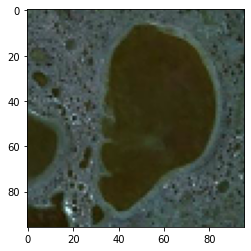

In [82]:
mtype='MAML'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

make_example(train_loader=train_loader, classes=classes)

In [83]:
if First_Train: model, MAML_loss_tracker, MAML_val_topks, MAML_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=MAML_learning_rate1, 
                                                                learning_rate1=MAML_learning_rate2, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype)
else: 
    model = get_model(mtype)
    MAML_loss_tracker=np.load(dir+'MAML_loss_tracker.npy')
    MAML_val_topks=np.load(dir+'MAML_val_topks.npy')
    MAML_val_accs=np.load(dir+'MAML_val_accs.npy')
    epoch_tracker=np.load(dir+'epoch_tracker.npy')

loading...


In [84]:
make_test(model=model, testloader=test_loader)

Test Accuracy:  55.427001953125
Test Top3 Accuracy:  78.4192123413086


## RESISC CNN

---

In [85]:
mtype='CNN'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

if First_Train: model, CNN_loss_tracker, CNN_val_topks, CNN_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=CNN_learning_rate, 
                                                                learning_rate1=CNN_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype)
else: 
    model = get_model(mtype)
    CNN_loss_tracker=np.load(dir+'CNN_loss_tracker.npy')
    CNN_val_topks=np.load(dir+'CNN_val_topks.npy')
    CNN_val_accs=np.load(dir+'CNN_val_accs.npy')

loading...


In [86]:
make_test(model=model, testloader=test_loader)

Test Accuracy:  67.23713684082031
Test Top3 Accuracy:  86.60260772705078


## RESISC CHARTS

---

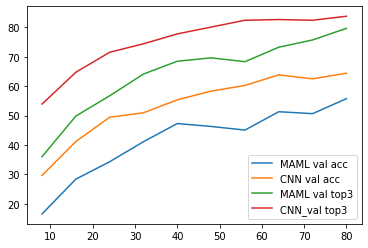

In [87]:
make_train_plot(MAML_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_val_accs, MAML_val_topks, CNN_val_topks, epoch_tracker)

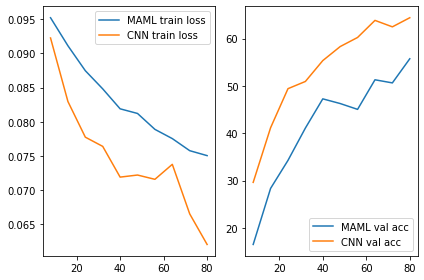

In [88]:
make_two_plots(epoch_tracker, MAML_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_val_accs)

## UC MERCED

---

In [89]:
UC_MAML_learning_rate = 0.0006
UC_CNN_learning_rate = 0.0006
UC_epochs = 3
UC_batch_size = 32

UC_data = np.load(dir+'UCMerced_images_96.npy')
UC_labels = np.load(dir+'UCMerced_classes.npy')
UC_classes = np.load(dir+'UCMerced_class_names.npy')

UC_train_data, UC_test_data, UC_train_labels, UC_test_labels = train_test_split(UC_data, UC_labels, test_size = 0.8, stratify = UC_labels)

UCtrainset = make_dataset(UC_train_data, UC_train_labels)
UCtrain_loader = DataLoader(UCtrainset, batch_size=int(batch_size), shuffle=True)

UCtestset = make_dataset(UC_test_data, UC_test_labels)
UCtest_loader = torch.utils.data.DataLoader(UCtestset, batch_size, drop_last = True, shuffle=True)

In [90]:
def UC_train(model, trainloader, epochs=3, lr=0.0006):
    loss_tracker, epoch_tracker = [], []
    #model.load('UC')
    model.train()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    for epoch in range(1, epochs+1):
        losses = 0
        for X, y in trainloader:
            y = one_hot_embedding(y.to(device), len(UC_classes)).float()
            X = X.float().to(device)
            for param in model.parameters(): param.grad = None
            yhat = model(X)
            pred_loss = bce_loss(yhat, y)
            pred_loss.backward()
            optimizer.step()
            losses += pred_loss.item()
        epoch_tracker.append(epoch)
        loss_tracker.append(losses)
        print(losses)
    return model, epoch_tracker, loss_tracker    

In [91]:
mtype='MAML'
model = get_model(mtype=mtype)

if freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, MAML_loss_tracker = UC_train(model=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2.3575463593006134
1.4800339713692665
1.0541289448738098


In [92]:
make_test(model=model, testloader=UCtest_loader)


Test Accuracy:  62.800479888916016
Test Top3 Accuracy:  86.59855651855469


In [93]:
mtype='CNN'
model = get_model(mtype=mtype)

if freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, CNN_loss_tracker = UC_train(model=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2.274312302470207
1.3750727251172066
0.9062096290290356


In [94]:
make_test(model=model, testloader=UCtest_loader)

Test Accuracy:  72.89663696289062
Test Top3 Accuracy:  91.88701629638672


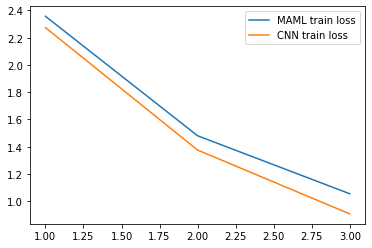

In [95]:
basic_train_plot(epoch_tracker, MAML_loss_tracker, CNN_loss_tracker)

## Scrap Work Area 

---

In [96]:
#GRAD DIAGNOSTICS
'''
print("PARAMS YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA == pB).all())
print("GRAD YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA.grad == pB.grad))
'''

'\nprint("PARAMS YOU ARE CHECKING")\nfor pA, pB in zip(CNN.parameters(), CNN1.parameters()):\n  print((pA == pB).all())\nprint("GRAD YOU ARE CHECKING")\nfor pA, pB in zip(CNN.parameters(), CNN1.parameters()):\n  print((pA.grad == pB.grad))\n'